# Building a MovieLens Recommender System

### What is MovieLens?

MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts. 

### Preview

This preview is broken down into 4 steps:

1. Importing the dependencies
1. Loading the data
1. Exploratory data analysis
1. Which Recommendation Approach will we use?

### Step 1: Import Dependencies

We are using [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) to represent our data. We will visualize our data with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

Let's download a full version of the MovieLens dataset. You can download the data [here](https://grouplens.org/datasets/movielens/latest/). 

<img src="..\demo\movieslen.jpg" width='50%'/>


We're working with data in `ml-latest.zip` and will need to add the following files to our project:

- ratings.csv
- movies.csv
- tags.csv
- links.csv

In [2]:
movies = pd.read_csv(r"..\extracted_data\ml-latest\movies.csv")
ratings = pd.read_csv(r"..\extracted_data\ml-latest\ratings.csv")
links = pd.read_csv(r"..\extracted_data\ml-latest\links.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Step 3: Exploratory data analysis 

In [6]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")
print(f"Sparsity: {1 - n_ratings/(n_users * n_movies):.4f}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975
Average number of ratings per user: 102.22
Average number of ratings per movie: 406.45
Sparsity: 0.9988


#### What is the distribution of movie ratings?

C:\Users\mo\AppData\Local\Temp\ipykernel_7860\2038653828.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


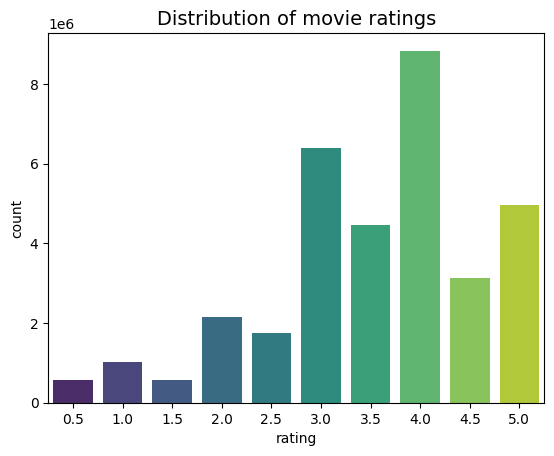

In [7]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [8]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.54.
Mean rating per user: 3.7.


#### Which movies are most frequently rated?

In [9]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)                         122296
Forrest Gump (1994)                                      113581
Pulp Fiction (1994)                                      108756
Matrix, The (1999)                                       107056
Silence of the Lambs, The (1991)                         101802
Star Wars: Episode IV - A New Hope (1977)                 97202
Fight Club (1999)                                         86207
Schindler's List (1993)                                   84232
Jurassic Park (1993)                                      83026
Star Wars: Episode V - The Empire Strikes Back (1980)     80200
Name: count, dtype: int64

`Shawshank Redemption`, `Forrest Gump`, and `Pulp Fiction` have the most ratings.

#### What are the lowest and highest rated movies? 

Which movie has the lowest and highest average rating?

In [10]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5694,5805,Besotted (2001),Drama


`Besotted` has the lowest average rating.

In [11]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
9644,31945,Always a Bridesmaid (2000),Documentary


`Always a Bridesmaid` has the highest average rating.

How many ratings does `Always a Bridesmaid` have?

In [12]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
12437693,122184,31945,5.0,1553102189


#### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [13]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [14]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 33681,
         'Comedy': 22830,
         'Thriller': 11675,
         'Romance': 10172,
         'Action': 9563,
         'Documentary': 9283,
         'Horror': 8570,
         '(no genres listed)': 7060,
         'Crime': 6917,
         'Adventure': 5349,
         'Sci-Fi': 4850,
         'Animation': 4579,
         'Children': 4367,
         'Mystery': 3972,
         'Fantasy': 3821,
         'War': 2301,
         'Western': 1690,
         'Musical': 1059,
         'Film-Noir': 354,
         'IMAX': 195})

In [15]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 33681), ('Comedy', 22830), ('Thriller', 11675), ('Romance', 10172), ('Action', 9563)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Romance` and `Action`.

Let's also visualize genres popularity with a barplot.

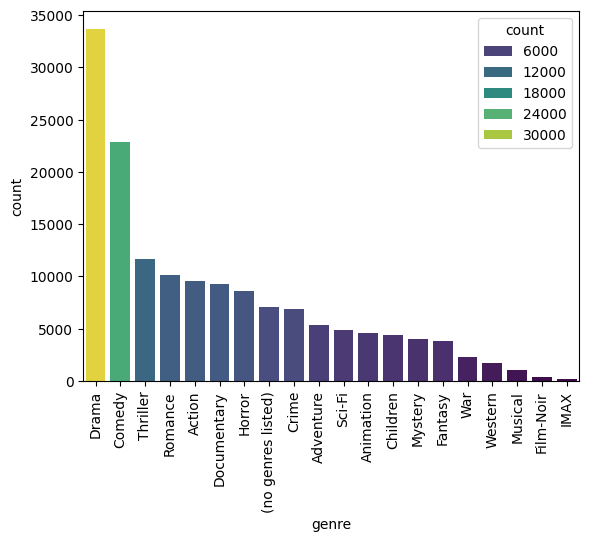

In [16]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), hue='count', palette='viridis')
plt.xticks(rotation=90)
plt.show()

### Step 4: Which Recommendation Approach will we use?

#### Item-Item Collaborative Filtering Using KNN

We are going to use a technique called collaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="../demo/user_movie_matrix.png" width=50%/>
<img src="..\demo\collaborative.png" width=40%/>